In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import glob

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import BinaryCrossentropy

import sklearn 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

from HigherTier import HigherTierModel
from HigherTier import PerformanceFuncs

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
#trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_*.npz')
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_track.npz')
print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_track.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

nEpochs = 10
batchSize = 64
learningRate = 1e-3

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 11))
variables_test = np.empty((0, 11))

# Truth
y_train = np.empty((0, 2))
y_test = np.empty((0, 2))
isTruePrimaryLink_train = np.empty((0), dtype='int')
isTruePrimaryLink_test = np.empty((0), dtype='int')

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)
    isTruePrimaryLink_train = np.concatenate((isTruePrimaryLink_train, data['isTruePrimaryLink_train']), axis=0)
    isTruePrimaryLink_test = np.concatenate((isTruePrimaryLink_test, data['isTruePrimaryLink_test']), axis=0)                                             

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('isTruePrimaryLink_train:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test:', isTruePrimaryLink_test.shape)                                            
                                            
nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_track.npz , This may take a while...
variables_train.shape: (377798, 11)
variables_test.shape: (41978, 11)
y_train.shape: (377798, 2)
y_test.shape: (41978, 2)
isTruePrimaryLink_train: (377798,)
isTruePrimaryLink_test: (41978,)


In [5]:
print(y_train)
print(isTruePrimaryLink_train)

[[1. 2.]
 [0. 0.]
 [2. 1.]
 ...
 [0. 0.]
 [1. 2.]
 [0. 0.]]
[1 0 1 ... 0 1 0]


In [6]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

variables_train.shape: (377798, 11)
variables_test.shape: (41978, 11)
y_train.shape: (377798, 2)
y_test.shape: (41978, 2)
isTruePrimaryLink_train.shape: (377798,)
isTruePrimaryLink_test.shape: (41978,)


In [7]:
###########################################################
# Split it into two again
###########################################################

n_links = 2
n_global_vars = 1
n_link_vars = 5

i_end_of_global_vars = n_global_vars
i_target_start = variables_train.shape[1] - n_link_vars
i_rest_start = n_global_vars
i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))

# Training
input_0_train = variables_train
input_1_train = np.concatenate((input_0_train[:,0:i_end_of_global_vars], input_0_train[:,i_target_start:], input_0_train[:,i_rest_start:i_rest_end]), axis=1)

input_train = np.concatenate((input_0_train, input_1_train), axis=0)
truth_train = np.concatenate((y_train[:,0], y_train[:,1]), axis=0).reshape(-1,1)

# Test
input_0_test = variables_test
input_1_test = np.concatenate((input_0_test[:,0:i_end_of_global_vars], input_0_test[:,i_target_start:], input_0_test[:,i_rest_start:i_rest_end]), axis=1)

input_test = np.concatenate((input_0_test, input_1_test), axis=0)
truth_test = np.concatenate((y_test[:,0], y_test[:,1]), axis=0).reshape(-1,1)

In [8]:
###########################################################
# Check shapes
###########################################################

print('input_0_train:', input_0_train.shape)
print('input_1_train:', input_1_train.shape)
print('input_train:', input_train.shape)
print('truth_train:', truth_train.shape)

print('input_0_test:', input_0_test.shape)
print('input_1_test:', input_1_test.shape)

print('input_test:', input_test.shape)
print('truth_test:', truth_test.shape)

input_0_train: (377798, 11)
input_1_train: (377798, 11)
input_train: (755596, 11)
truth_train: (755596, 1)
input_0_test: (41978, 11)
input_1_test: (41978, 11)
input_test: (83956, 11)
truth_test: (83956, 1)


In [9]:
###########################################################
# Define class weights
###########################################################
nTrue = np.count_nonzero(truth_train == 1)
nWrongOrientation = np.count_nonzero(truth_train == 2)
nBackground = np.count_nonzero(truth_train == 0)
maxLinks = max(nTrue, nWrongOrientation, nBackground)

print('nTrue:', nTrue)
print('nWrongOrientation:', nWrongOrientation)
print('nBackground:', nBackground)

classWeights = {0: maxLinks/nBackground, 1: maxLinks/nTrue, 2: maxLinks/nWrongOrientation}

print('classWeights:', classWeights)

nTrue: 275494
nWrongOrientation: 275494
nBackground: 204608
classWeights: {0: 1.3464478417266188, 1: 1.0, 2: 1.0}


In [10]:
###########################################################
# Change format of truth labels
###########################################################

isTruePrimaryLink_train = isTruePrimaryLink_train.reshape(-1, 1)
isTruePrimaryLink_test = isTruePrimaryLink_test.reshape(-1, 1)

# Use categorical

isTruePrimaryLink_train = to_categorical(isTruePrimaryLink_train, 2)
isTruePrimaryLink_test = to_categorical(isTruePrimaryLink_test, 2)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

truth_train = to_categorical(truth_train, 3)
truth_test = to_categorical(truth_test, 3)

In [11]:
###########################################################
# Define model and optimiser and compile the model
###########################################################

model = HigherTierModel.HigherTierModel(nVariables)
optimiser = optimizers.legacy.Adam(learning_rate=learningRate)
model.compile(optimizer=optimiser, metrics=['accuracy'], loss=['categorical_crossentropy'])


In [12]:
###########################################################
# Fit the model
###########################################################

filePath = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track'
    
# checkpoint
checkpoint = ModelCheckpoint(filePath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(input_train, truth_train, validation_data=(input_test, truth_test), 
                    batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list, class_weight=classWeights)

Epoch 1/10
11781/11807 [============================>.] - ETA: 0s - loss: 0.5384 - accuracy: 0.8024
Epoch 1: val_accuracy improved from -inf to 0.82322, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


11807/11807 [==============================] - 11s 917us/step - loss: 0.5383 - accuracy: 0.8024 - val_loss: 0.4269 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 2/10
11778/11807 [============================>.] - ETA: 0s - loss: 0.4968 - accuracy: 0.8172
Epoch 2: val_accuracy improved from 0.82322 to 0.82808, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


11807/11807 [==============================] - 11s 919us/step - loss: 0.4968 - accuracy: 0.8172 - val_loss: 0.4198 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 3/10
11749/11807 [============================>.] - ETA: 0s - loss: 0.4892 - accuracy: 0.8198
Epoch 3: val_accuracy improved from 0.82808 to 0.82996, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


11807/11807 [==============================] - 11s 920us/step - loss: 0.4891 - accuracy: 0.8198 - val_loss: 0.4155 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/10
11767/11807 [============================>.] - ETA: 0s - loss: 0.4857 - accuracy: 0.8210
Epoch 4: val_accuracy improved from 0.82996 to 0.83034, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


11807/11807 [==============================] - 11s 910us/step - loss: 0.4857 - accuracy: 0.8211 - val_loss: 0.4115 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 5/10
11763/11807 [============================>.] - ETA: 0s - loss: 0.4834 - accuracy: 0.8213
Epoch 5: val_accuracy improved from 0.83034 to 0.83314, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


11807/11807 [==============================] - 12s 985us/step - loss: 0.4835 - accuracy: 0.8212 - val_loss: 0.4268 - val_accuracy: 0.8331 - lr: 0.0010
Epoch 6/10
11793/11807 [============================>.] - ETA: 0s - loss: 0.4819 - accuracy: 0.8219
Epoch 6: val_accuracy did not improve from 0.83314

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
11807/11807 [==============================] - 11s 890us/step - loss: 0.4819 - accuracy: 0.8219 - val_loss: 0.4185 - val_accuracy: 0.8309 - lr: 0.0010
Epoch 7/10
11779/11807 [============================>.] - ETA: 0s - loss: 0.4732 - accuracy: 0.8252
Epoch 7: val_accuracy improved from 0.83314 to 0.83554, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_individual_link_model_track/assets


11807/11807 [==============================] - 11s 909us/step - loss: 0.4732 - accuracy: 0.8252 - val_loss: 0.4138 - val_accuracy: 0.8355 - lr: 1.0000e-04
Epoch 8/10
11783/11807 [============================>.] - ETA: 0s - loss: 0.4709 - accuracy: 0.8258
Epoch 8: val_accuracy did not improve from 0.83554

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
11807/11807 [==============================] - 10s 883us/step - loss: 0.4710 - accuracy: 0.8258 - val_loss: 0.4129 - val_accuracy: 0.8345 - lr: 1.0000e-04
Epoch 9/10
11751/11807 [============================>.] - ETA: 0s - loss: 0.4699 - accuracy: 0.8257
Epoch 9: val_accuracy did not improve from 0.83554
11807/11807 [==============================] - 10s 885us/step - loss: 0.4700 - accuracy: 0.8257 - val_loss: 0.4126 - val_accuracy: 0.8350 - lr: 1.0000e-05
Epoch 10/10
11755/11807 [============================>.] - ETA: 0s - loss: 0.4694 - accuracy: 0.8261
Epoch 10: val_accuracy did not improve from 0.83554

E

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


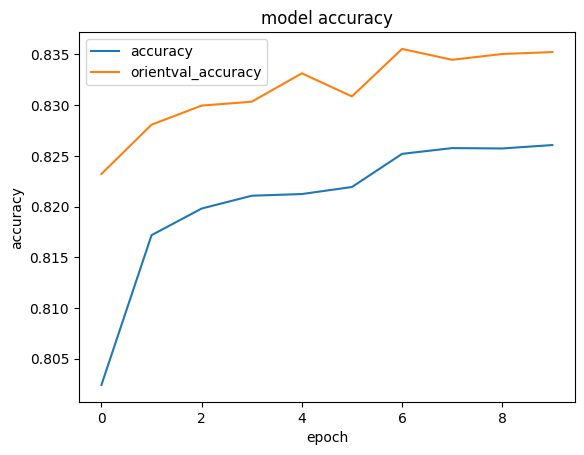

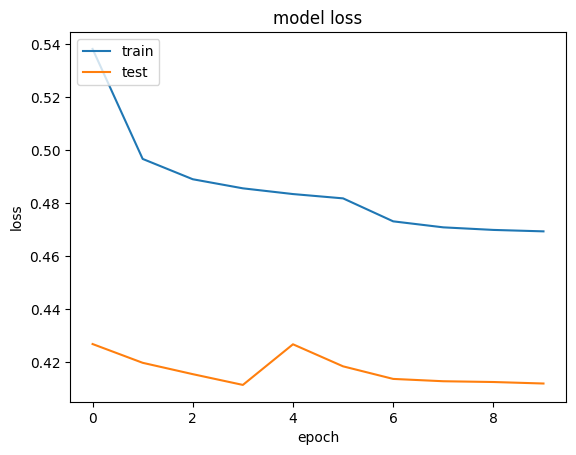

In [13]:
###########################################################
# Evaluate training
###########################################################

import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'orientval_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_train = model.predict(input_train)
y_pred_test = model.predict(input_test)

2624/2624 [==============================] - 1s 296us/step


In [15]:
###########################################################
# Reshape the prediction for next network
###########################################################
y_pred_0_train = y_pred_train[0:ntrain].reshape(-1, 1, 3)
y_pred_1_train = y_pred_train[ntrain:(ntrain * 2)].reshape(-1, 1, 3)
input_final_train = np.concatenate((y_pred_0_train, y_pred_1_train), axis=1).reshape(-1, 6)

y_pred_0_test = y_pred_test[0:ntest].reshape(-1, 1, 3)
y_pred_1_test = y_pred_test[ntest:(ntest * 2)].reshape(-1, 1, 3)
input_final_test = np.concatenate((y_pred_0_test, y_pred_1_test), axis=1).reshape(-1, 6)


In [16]:
print(input_final_train[0])
print(isTruePrimaryLink_train[0])

[0.03519281 0.9494614  0.01534583 0.03970813 0.02190352 0.93838835]
[0. 1.]


In [17]:
###########################################################
# Reshape the prediction and truth labels for metrics
###########################################################

pred_individual_links_train = input_final_train.reshape(-1, 3)
y_train = y_train.reshape(-1, 3)

pred_individual_links_test = input_final_test.reshape(-1, 3)
y_test = y_test.reshape(-1, 3)

In [18]:
print(isTruePrimaryLink_train[0])
print(y_train[1])

[0. 1.]
[0. 0. 1.]


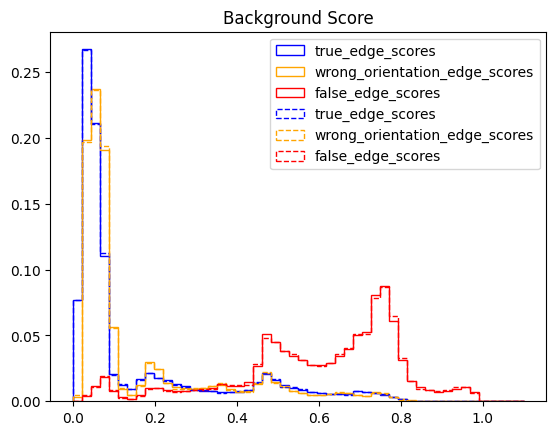

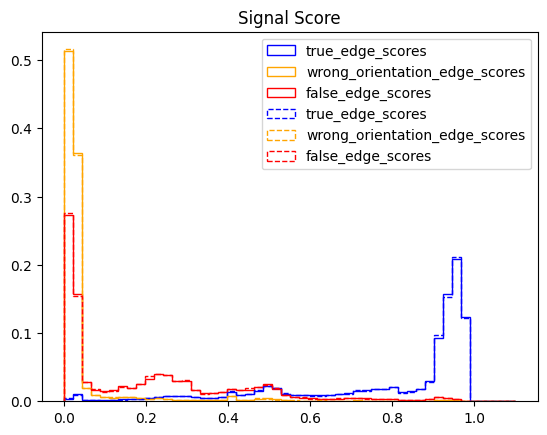

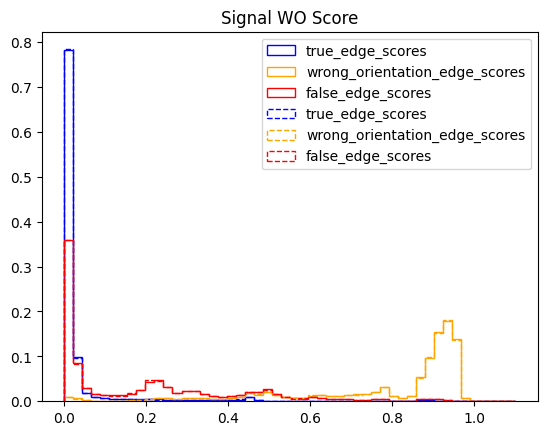

[[17137  2800  3115]
 [ 3160 26385   907]
 [ 2888   963 26601]]


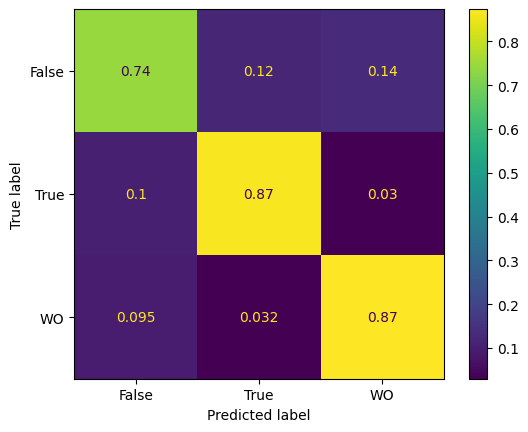

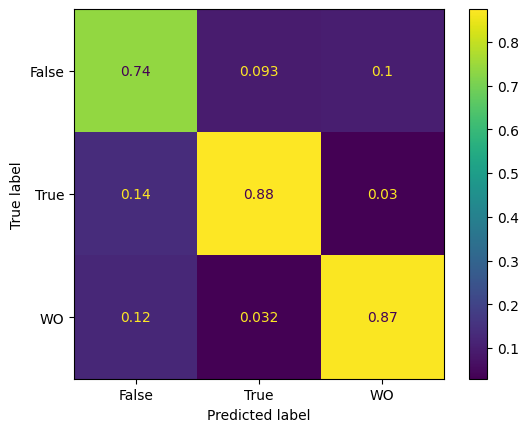

In [19]:
#######################################
# Plot edge scores
#######################################

PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 0)
PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 1)
PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 2)
PerformanceFuncs.draw_confusion_multi(pred_individual_links_test, y_test)

In [20]:
###########################################################
# Define the model and optimiser and compile the model
###########################################################

model_final = HigherTierModel.HigherTierFinalOutputModel(6, dropoutRate=0.5)
optimiser_final = optimizers.legacy.Adam(learning_rate=learningRate)
model_final.compile(optimizer=optimiser_final, metrics=['accuracy'], loss=['binary_crossentropy'])

In [21]:
###########################################################
# Define class weights
###########################################################

nTrue_final = np.count_nonzero(isTruePrimaryLink_train.argmax(axis=1) == 1)
nBackground_final = np.count_nonzero(isTruePrimaryLink_train.argmax(axis=1) == 0)

maxLinks = max(nTrue_final, nBackground_final)

classWeights_final = {0: maxLinks/nBackground_final, 1: maxLinks/nTrue_final}

print('nTrue_final:', nTrue_final)
print('nBackground_final:', nBackground_final)
print('classWeights_final:', classWeights_final)

nTrue_final: 275494
nBackground_final: 102304
classWeights_final: {0: 2.6928956834532376, 1: 1.0}


In [22]:
###########################################################
# Reshape for sigmoid training
###########################################################

isTruePrimaryLink_train = isTruePrimaryLink_train.argmax(axis=1).reshape((-1,1))
isTruePrimaryLink_test = isTruePrimaryLink_test.argmax(axis=1).reshape((-1,1))

In [23]:
###########################################################
# Fit the model
###########################################################

filePath_final = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track'
    
# checkpoint
checkpoint_final = ModelCheckpoint(filePath_final, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list_final = [checkpoint_final, reduce_lr_final]

history_final = model_final.fit(input_final_train, isTruePrimaryLink_train, validation_data=(input_final_test, isTruePrimaryLink_test), 
                          batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list_final, class_weight=classWeights_final)

Epoch 1/10
5791/5904 [============================>.] - ETA: 0s - loss: 0.6243 - accuracy: 0.8167
Epoch 1: val_accuracy improved from -inf to 0.84428, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track/assets


5904/5904 [==============================] - 3s 408us/step - loss: 0.6225 - accuracy: 0.8172 - val_loss: 0.3683 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 2/10
5768/5904 [============================>.] - ETA: 0s - loss: 0.5267 - accuracy: 0.8454
Epoch 2: val_accuracy improved from 0.84428 to 0.84473, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track/assets


5904/5904 [==============================] - 2s 409us/step - loss: 0.5267 - accuracy: 0.8454 - val_loss: 0.3657 - val_accuracy: 0.8447 - lr: 0.0010
Epoch 3/10
5781/5904 [============================>.] - ETA: 0s - loss: 0.5266 - accuracy: 0.8454
Epoch 3: val_accuracy did not improve from 0.84473
5904/5904 [==============================] - 2s 386us/step - loss: 0.5267 - accuracy: 0.8454 - val_loss: 0.3666 - val_accuracy: 0.8446 - lr: 0.0010
Epoch 4/10
5802/5904 [============================>.] - ETA: 0s - loss: 0.5266 - accuracy: 0.8455
Epoch 4: val_accuracy did not improve from 0.84473

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5904/5904 [==============================] - 2s 385us/step - loss: 0.5267 - accuracy: 0.8454 - val_loss: 0.3664 - val_accuracy: 0.8445 - lr: 0.0010
Epoch 5/10
5765/5904 [============================>.] - ETA: 0s - loss: 0.5266 - accuracy: 0.8456
Epoch 5: val_accuracy did not improve from 0.84473
5904/5904 [====================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


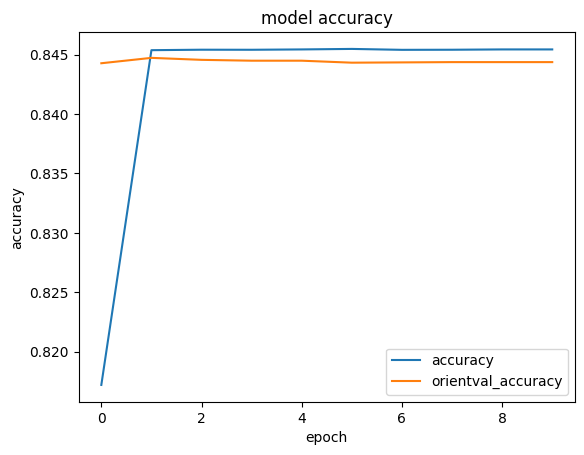

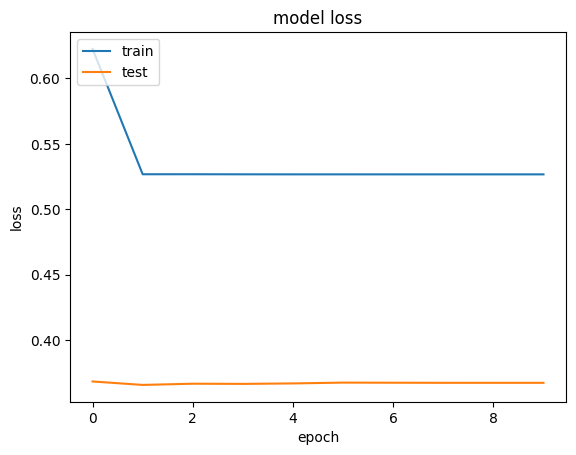

In [24]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history_final.history.keys())

# summarize history for accuracy
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'orientval_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_final_train = model_final.predict(input_final_train)
y_pred_final_test = model_final.predict(input_final_test)

1312/1312 [==============================] - 0s 244us/step


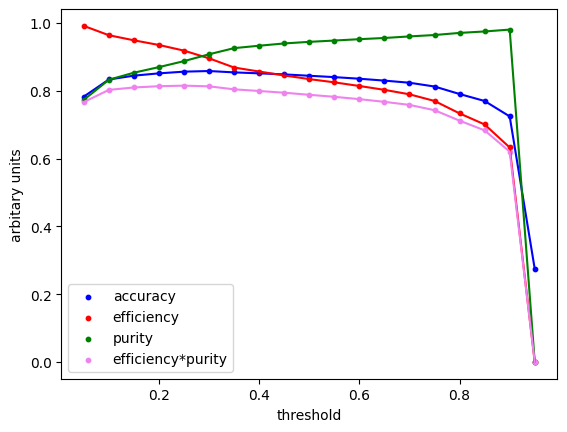

optimal_threshold_metric: 0.25


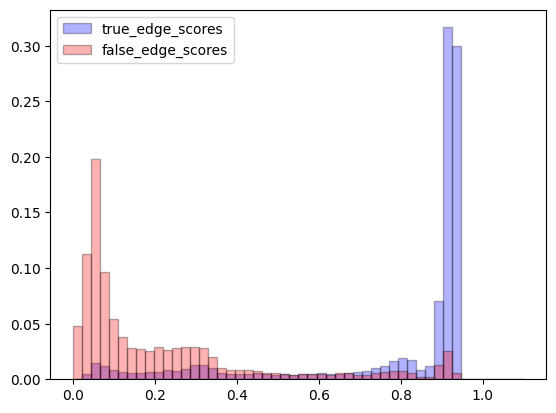

[[10031  1495]
 [ 5038 25414]]
[[ 7983  3543]
 [ 2482 27970]]


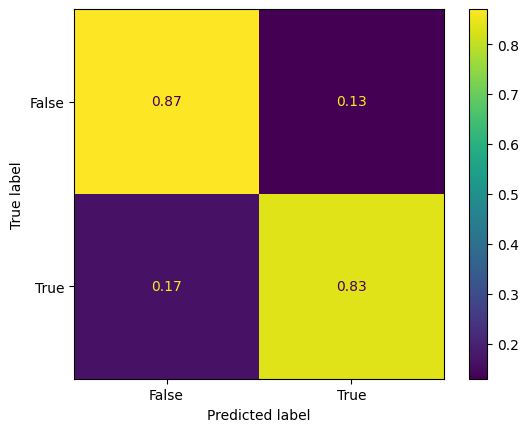

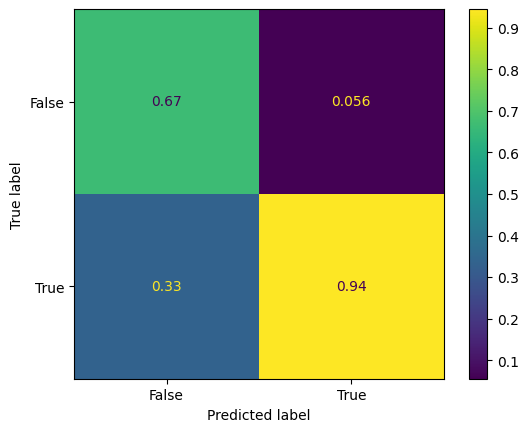

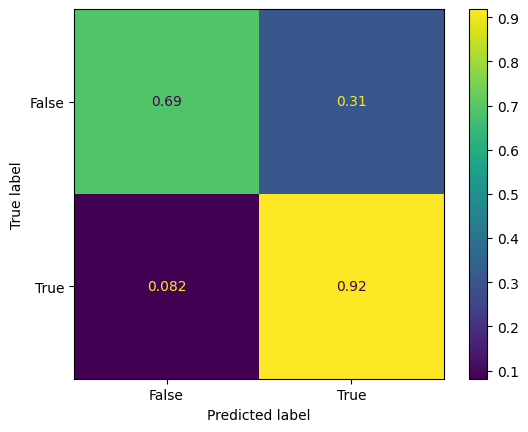

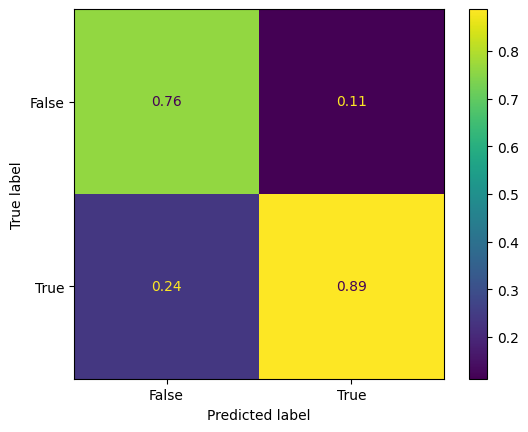

In [26]:
#######################################
# Plot final link prediction
#######################################

optimal_threshold, max_accuracy, optimal_threshold_metric, max_metric = PerformanceFuncs.calculate_accuracy(y_pred_final_test, isTruePrimaryLink_test)

print('optimal_threshold_metric:', optimal_threshold_metric)

PerformanceFuncs.plot_scores(y_pred_final_test, isTruePrimaryLink_test)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, isTruePrimaryLink_test, 0.5)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, isTruePrimaryLink_test, optimal_threshold_metric)
